# Created by Abas Moahammedidris

# =======EfficientNet-B6_Unet & EfficientNet-B_Unet =======

# 1:Import required libaries 

In [1]:
import os
import json

import gc

import albumentations as albu
import cv2
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate,BatchNormalization,LeakyReLU,concatenate
from tensorflow.keras.losses import binary_crossentropy , categorical_crossentropy 
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import multiprocessing
num_cores = multiprocessing.cpu_count()
from matplotlib import pyplot as plt
#import segmentation_models a

In [2]:
!pip install keras-rectified-adam

In [2]:
from keras_radam import RAdam

In [3]:
num_cores = multiprocessing.cpu_count()
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=8,
    inter_op_parallelism_threads=8,
    allow_soft_placement=True,device_count = {'CPU' : 1, 'GPU' : 1})

# 2: Load dataset

In [4]:
train_df = pd.read_csv('C:\\Users\\abasd\\OneDrive - Coventry University\\Masters\\MSc thesis\\Code\\cloud_dataset\\train.csv')
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(22184, 5)


Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2  0011165.jpg_Gravel                                                NaN   
3   0011165.jpg_Sugar                                                NaN   
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   

       ImageId ClassId  hasMask  
0  0011165.jpg    Fish     True  
1  0011165.jpg  Flower     True  
2  0011165.jpg  Gravel    False  
3  0011165.jpg   Sugar    False  
4  002be4f.jpg    Fish     True

In [5]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(5546, 2)


ImageId  hasMask
821   24dd99c.jpg        4
1885  562f80a.jpg        4
3260  944f10b.jpg        4
1872  55b539f.jpg        4
4464  cdf7242.jpg        4

In [6]:
sub_df = pd.read_csv('D:\\Thesis_code_and_dataset\\Code\\sample_submission.csv')
sub_df['ImageId'] = sub_df['Image_Label'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

# 3:Helper functions

In [7]:
def np_resize(img, input_shape):
    """
    Reshape a numpy array, which is input_shape=(height, width), 
    as opposed to input_shape=(width, height) for cv2
    """
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles
## visualisation function

def visualize(image, mask, mask_prediction):
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    f, ax = plt.subplots(2, 5, figsize=(24,8))

    ax[0, 0].imshow(image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
    
    ax[1, 0].imshow(image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(mask_prediction[:, :, i])
        ax[1, i + 1].set_title(f'Prediction {class_dict[i]}', fontsize=fontsize)

# 4: Evaluation metrices

In [8]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

# 5: DataGenerator Class

In [ ]:
## this datagenerator was adapted from keras website and https://www.kaggle.com/xhlulu/severstal-u-net-with-efficientnetb4

In [9]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='C:\\Users\\abasd\\OneDrive - Coventry University\\Masters\\MSc thesis\\Code\\cloud_dataset\\train_images',
                 
                 batch_size=4, dim=(1400, 2100), n_channels=3, reshape=None,
                 augment=False, n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.augment = augment
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()
        np.random.seed(self.random_state)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            #######
            y = tf.cast(y, tf.float64)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_rgb(img_path)
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            
            # Store samples
            X[i,] = img #cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).reshape((img.shape[0],img.shape[1],1))

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks
            #print(y)
        #y = tf.cast(y, tf.float32)

        return y
    #assert os.path.exists(that_path)
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img
    
    def __random_transform(self, img, masks):
        composition = albu.Compose([
            albu.HorizontalFlip(),
            albu.VerticalFlip(),
            albu.ShiftScaleRotate(rotate_limit=45, shift_limit=0.15, scale_limit=0.15)
        ])
        
        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(
                img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch
    
    def getitem(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            y = tf.cast(y, tf.float32)
            
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')

# 6: generate training , valdiation and checking data using DataGenerator 

In [10]:
BATCH_SIZE = 4

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=2021, test_size=0.2
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    reshape=(128, 256),
    augment=True,
    n_channels=3,
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    reshape=(128, 256),
    augment=False,
    n_channels=3,
    n_classes=4
)

check_generator = DataGenerator(
    val_idx[0:10], 
    df=mask_count_df, 
    mode='predict',
    shuffle=False,
    reshape=(128, 256),
    augment=False,
    n_channels=3,
    n_classes=4,
    batch_size=4,
)

## 6.1 : check data shape before passing it to a model

In [11]:
# check out the shapes
x, y = train_generator.__getitem__(0)
print(x.shape, y.shape)
print(x.dtype, y.dtype)

(4, 128, 256, 3) (4, 128, 256, 4)
float64 <dtype: 'float64'>


# 7: Building EFF_Unet6

In [12]:
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.applications import EfficientNetB7
input_shape=(128,256,3)

In [ ]:
## this code was addressed from https://www.kaggle.com/xhlulu/severstal-u-net-with-efficientnetb4

In [13]:
def H(lst, name, use_gn=False):
    if use_gn:
        norm = GroupNormalization(groups=1, name=name+'_gn')
    else:
        norm = BatchNormalization(name=name+'_bn')
    
    x = concatenate(lst)
    num_filters = int(x.shape.as_list()[-1]/2)
    
    x = Conv2D(num_filters, (2, 2), padding='same', name=name)(x)
    x = norm(x)
    x = LeakyReLU(alpha=0.1, name=name+'_activation')(x)
    
    return x

def U(x, use_gn=False):
    if use_gn:
        norm = GroupNormalization(groups=1)
    else:
        norm = BatchNormalization()
    
    num_filters = int(x.shape.as_list()[-1]/2)
    
    x = Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding='same')(x)
    x = norm(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    return x

In [17]:

def Efficient6_UNet(input_shape):
    backbone = EfficientNetB6(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    input = backbone.input
    x00 = backbone.input  # (256, 512, 3)
    x10 = backbone.get_layer('stem_activation').output  # (128, 256, 4)
    x20 = backbone.get_layer('block2d_add').output  # (64, 128, 32)
    x30 = backbone.get_layer('block3d_add').output  # (32, 64, 56)
    x40 = backbone.get_layer('block5f_add').output  # (16, 32, 160)
    x50 = backbone.get_layer('block7b_add').output  # (8, 16, 448)
    
    x01 = H([x00, U(x10)], 'X01')
    x11 = H([x10, U(x20)], 'X11')
    x21 = H([x20, U(x30)], 'X21')
    x31 = H([x30, U(x40)], 'X31')
    x41 = H([x40, U(x50)], 'X41')
    
    x02 = H([x00, x01, U(x11)], 'X02')
    x12 = H([x11, U(x21)], 'X12')
    x22 = H([x21, U(x31)], 'X22')
    x32 = H([x31, U(x41)], 'X32')
    
    x03 = H([x00, x01, x02, U(x12)], 'X03')
    x13 = H([x12, U(x22)], 'X13')
    x23 = H([x22, U(x32)], 'X23')
    
    x04 = H([x00, x01, x02, x03, U(x13)], 'X04')
    x14 = H([x13, U(x23)], 'X14')
    
    x05 = H([x00, x01, x02, x03, x04, U(x14)], 'X05')
    
    x_out = Concatenate(name='bridge')([x01, x02, x03, x04, x05])
    x_out = Conv2D(4, (3,3), padding="same", name='final_output', activation="sigmoid")(x_out)
    
    return Model(inputs=input, outputs=x_out)

model_EFF_b61 = Efficient6_UNet((128, 256,3))

model_EFF_b61.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 128, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 128, 256, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 257, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

# 8: Compile , train and evaluate Eff_Unet6 using Dice accuracy and loss

## 8.1 compile model

In [15]:
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [16]:
checkpoint = ModelCheckpoint('model_EFF_b6.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=ES_PATIENCE,
                   restore_best_weights=True,
                   verbose=1)

rlrop = ReduceLROnPlateau(monitor='val_loss',
                          mode='min',
                          patience=RLROP_PATIENCE,
                          factor=DECAY_DROP,
                          min_lr=1e-6,
                          verbose=1)

model_EFF_b6.compile(optimizer=RAdam(learning_rate=0.0002), loss=bce_dice_loss, metrics=[dice_coef])
model_EFF_b6.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 128, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 257, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

## 8.2:Train and Evaluate Model with Dice Coef

In [48]:
%%time
#checkpoint = ModelCheckpoint('model_0EFU6.h5', save_best_only=True)
history_EFU66 = model_EFF_b6.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, es, rlrop],
    epochs=30
)

Epoch 1/30
1109/1109 [==============================] - 1208s 1s/step - loss: 1.0693 - dice_coef: 0.3305 - val_loss: 1.3039 - val_dice_coef: 0.2429
Epoch 2/30
1109/1109 [==============================] - 1123s 1s/step - loss: 0.9345 - dice_coef: 0.4221 - val_loss: 2.8995 - val_dice_coef: 0.0057
Epoch 3/30
1109/1109 [==============================] - 1119s 1s/step - loss: 0.8965 - dice_coef: 0.4486 - val_loss: 3.6578 - val_dice_coef: 0.0061
Epoch 4/30
1109/1109 [==============================] - 1120s 1s/step - loss: 0.8706 - dice_coef: 0.4653 - val_loss: 1.4324 - val_dice_coef: 0.2220

Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Epoch 5/30
1109/1109 [==============================] - 1123s 1s/step - loss: 0.8356 - dice_coef: 0.4879 - val_loss: 0.8190 - val_dice_coef: 0.4917
Epoch 6/30
1109/1109 [==============================] - 1120s 1s/step - loss: 0.8148 - dice_coef: 0.5010 - val_loss: 0.9435 - val_dice_coef: 0.4400
Epoch 7/30
1109/1109 [=========

In [20]:
 #save the model
model_EFF_b6.save("history_EFU66.h5py")

C:\Users\abasd\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: history_EFU66.h5py\assets


## 8.3: plot dice coef and dice loss

In [24]:
with open('history_EFU66.json', 'w') as f:
    json.dump(str(history_EFU66.history), f)

history_df = pd.DataFrame(history_EFU66.history)
plt=history_df[['loss', 'val_loss']].plot()
plt.set_title("training and validation loss with EFF_Unet6")
plt1=history_df[['dice_coef', 'val_dice_coef']].plot()
plt1.set_title("training and validation dice_coef with EFF_Unet6")

##  make some mask prediction with Eff_Unet6

In [50]:
#model.load_weights('model_0.h5')

batch_pred_masks = model_EFF_b6.predict(
    check_generator, 
    workers=1,
    verbose=1
)

2/2 [==============================] - 3s 237ms/step


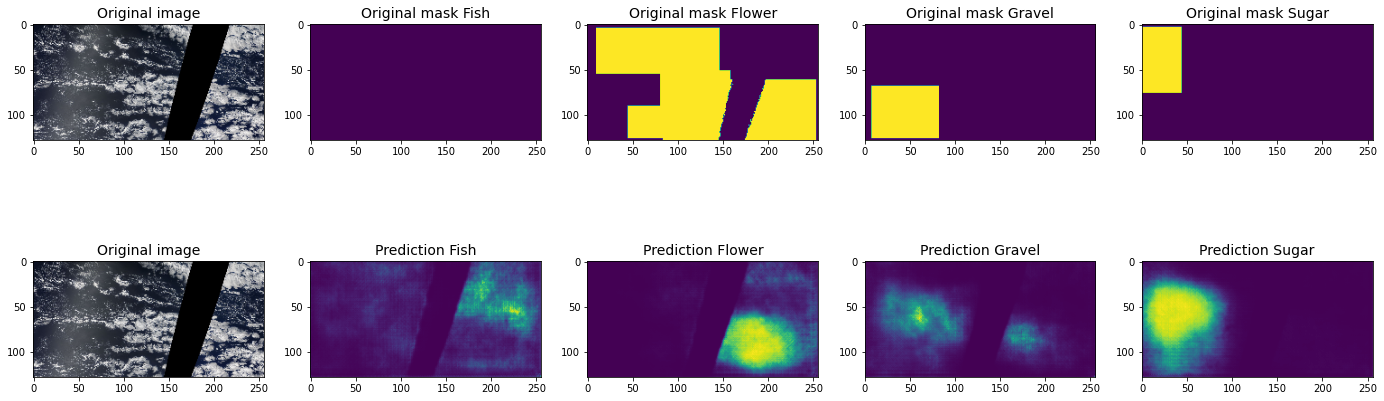

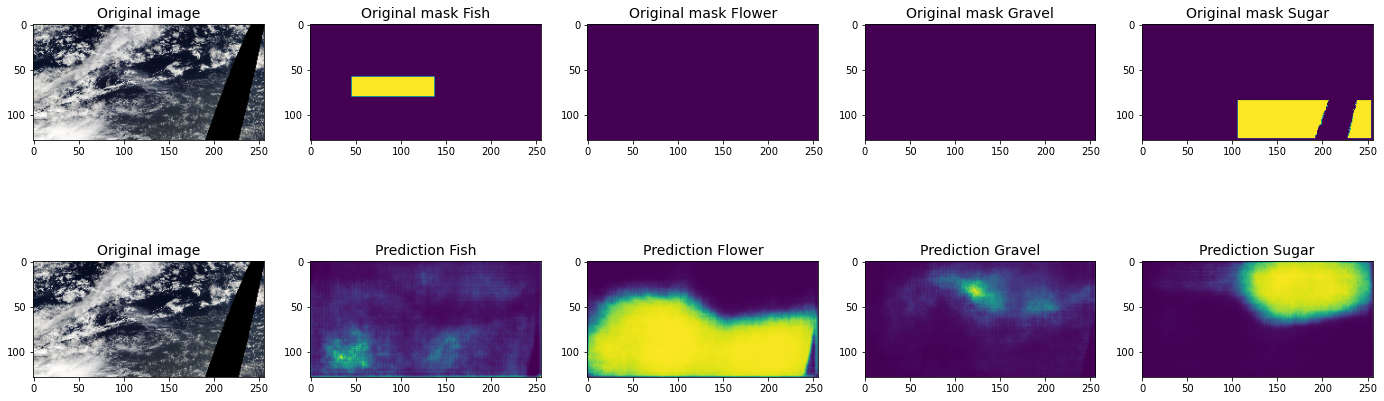

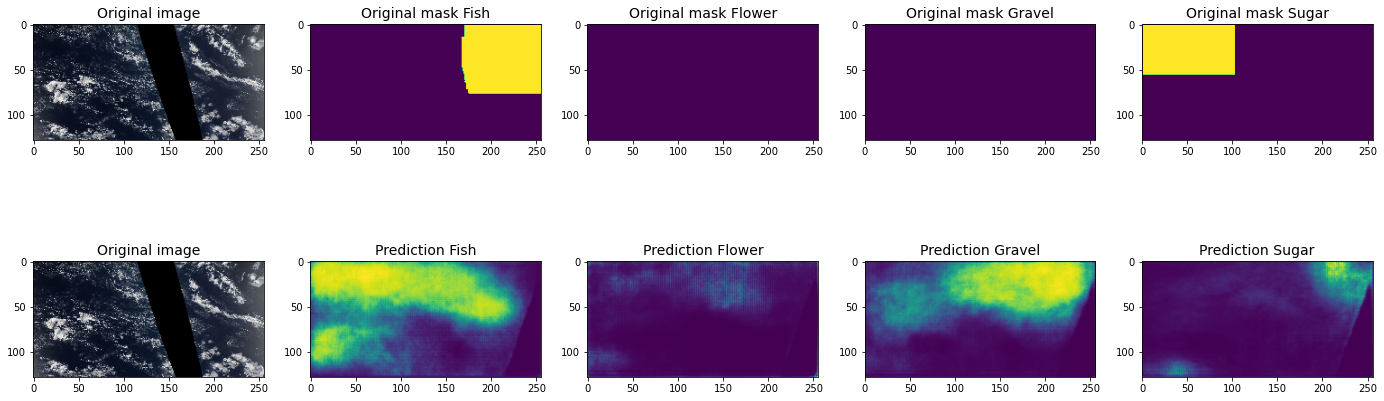

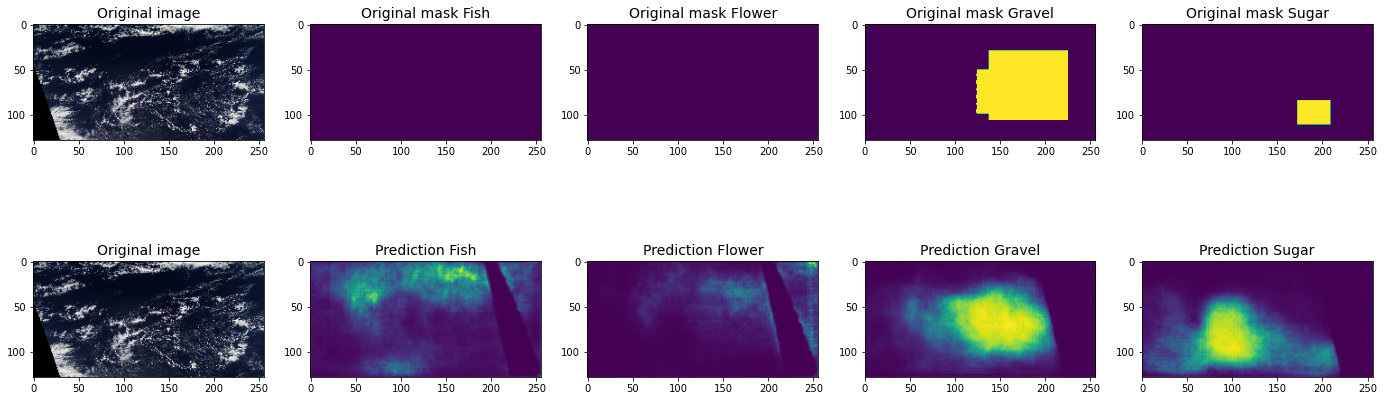

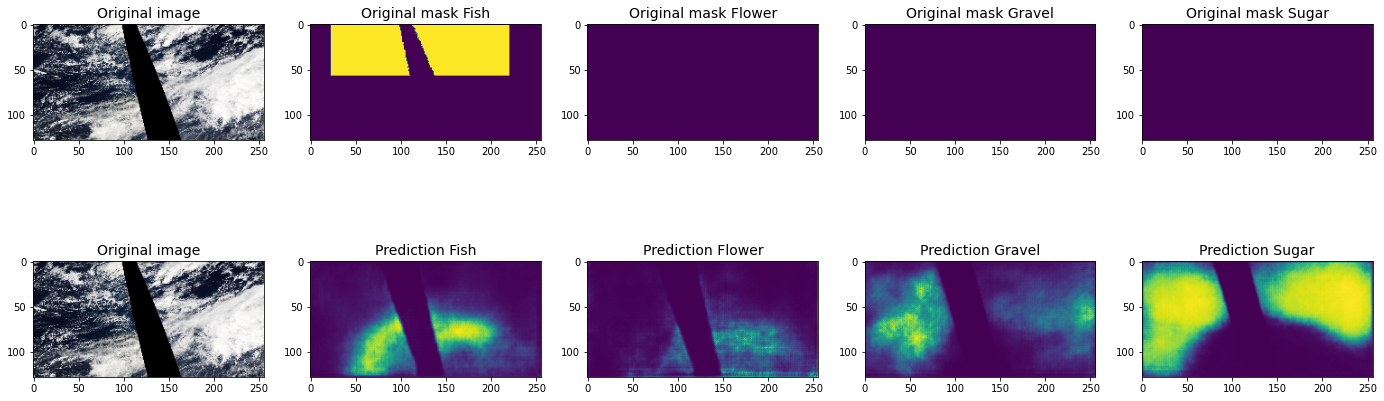

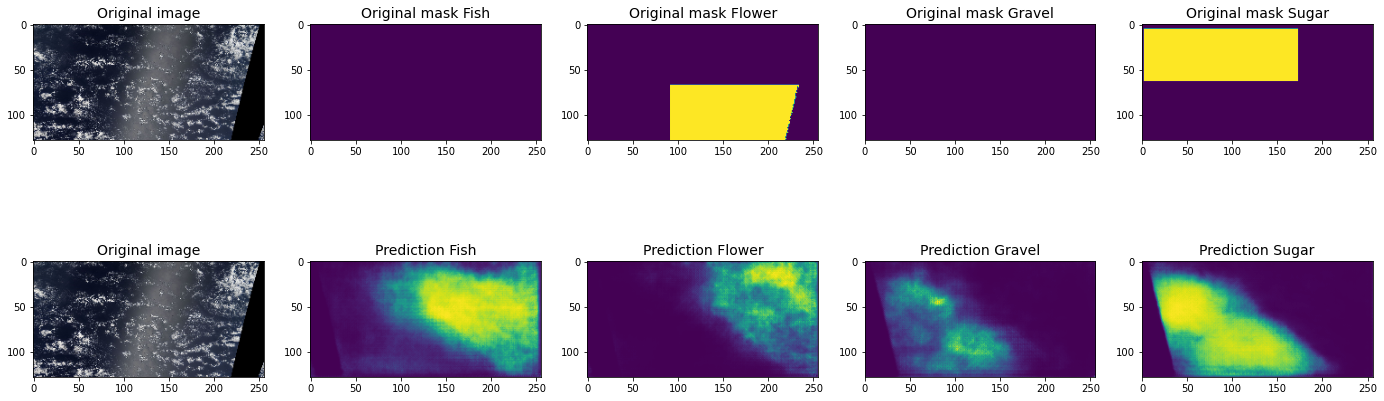

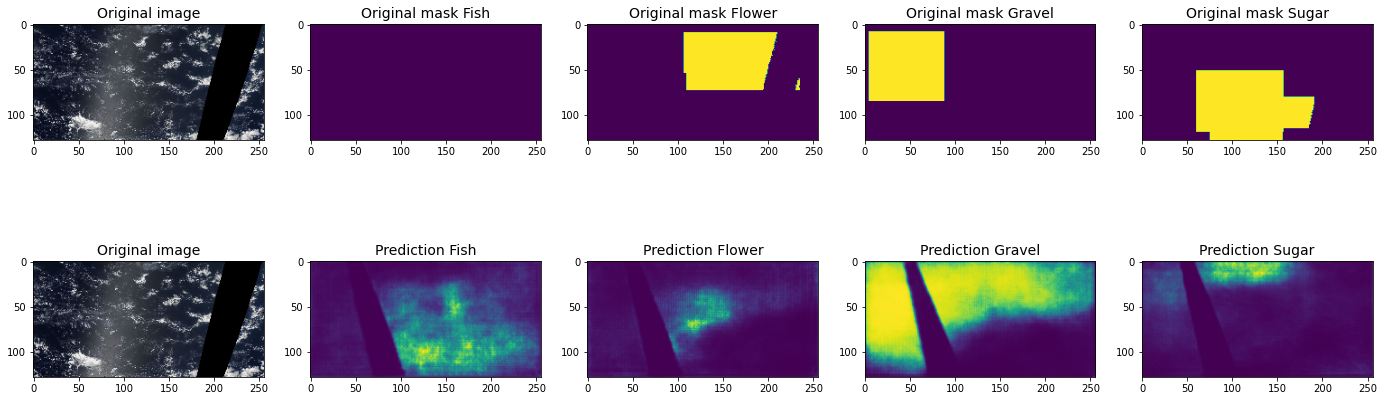

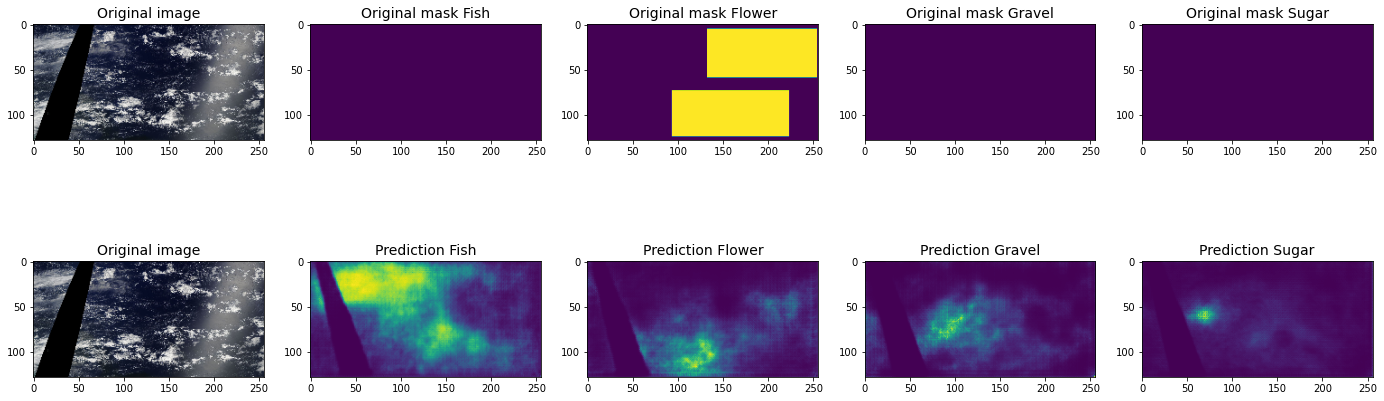

In [51]:
from matplotlib import pyplot as plt
for i in range(8):
    visualize(val_generator.getitem(i)[0][0,:,:,:],val_generator.getitem(i)[1][0,:,:,:],batch_pred_masks[i])

#  Compile , train and evaluate Eff_Unet6 using IoU

In [18]:
checkpoint = ModelCheckpoint('model_EFF_b61.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=ES_PATIENCE,
                   restore_best_weights=True,
                   verbose=1)

rlrop = ReduceLROnPlateau(monitor='val_loss',
                          mode='min',
                          patience=RLROP_PATIENCE,
                          factor=DECAY_DROP,
                          min_lr=1e-6,
                          verbose=1)

model_EFF_b61.compile(optimizer=RAdam(learning_rate=0.0002), loss=[jacard_coef_loss], metrics=[jacard_coef])
model_EFF_b61.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 128, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 128, 256, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 257, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [19]:
%%time
#checkpoint = ModelCheckpoint('model_0EFU6.h5', save_best_only=True)
history_EFU611 = model_EFF_b61.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, es, rlrop],
    epochs=30
)

Epoch 1/30
1109/1109 [==============================] - 1213s 1s/step - loss: -0.2538 - jacard_coef: 0.2538 - val_loss: -0.1185 - val_jacard_coef: 0.1185
Epoch 2/30
1109/1109 [==============================] - 1155s 1s/step - loss: -0.3341 - jacard_coef: 0.3341 - val_loss: -0.1601 - val_jacard_coef: 0.1601
Epoch 3/30
1109/1109 [==============================] - 1154s 1s/step - loss: -0.3494 - jacard_coef: 0.3494 - val_loss: -0.1386 - val_jacard_coef: 0.1386
Epoch 4/30
1109/1109 [==============================] - 1145s 1s/step - loss: -0.3599 - jacard_coef: 0.3599 - val_loss: -0.1257 - val_jacard_coef: 0.1257
Epoch 5/30
1109/1109 [==============================] - 1150s 1s/step - loss: -0.3682 - jacard_coef: 0.3682 - val_loss: -0.1337 - val_jacard_coef: 0.1337

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Epoch 6/30
1109/1109 [==============================] - 1154s 1s/step - loss: -0.3851 - jacard_coef: 0.3851 - val_loss: -0.3481 - val_jacard_coef: 0.

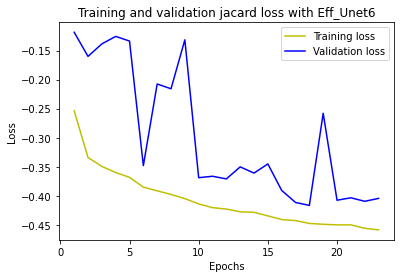

In [21]:
from matplotlib import pyplot as plt
loss = history_EFU611.history['loss']
val_loss = history_EFU611.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation jacard loss with Eff_Unet6')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

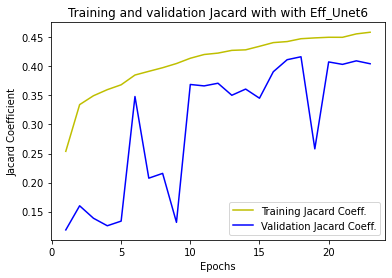

In [22]:
from matplotlib import pyplot as plt
jc = history_EFU611.history['jacard_coef']
#acc = history.history['accuracy']
val_jc = history_EFU611.history['val_jacard_coef']
#val_acc = history.history['val_accuracy']
#epochs = range(1, len(loss) + 1)

plt.plot(epochs, jc, 'y', label='Training Jacard Coeff.')
plt.plot(epochs, val_jc, 'b', label='Validation Jacard Coeff.')
plt.title('Training and validation Jacard with with Eff_Unet6')
plt.xlabel('Epochs')
plt.ylabel('Jacard Coefficient')
plt.legend()
plt.show()

# Eff_UNet7

In [19]:
def H(lst, name, use_gn=False):
    if use_gn:
        norm = GroupNormalization(groups=1, name=name+'_gn')
    else:
        norm = BatchNormalization(name=name+'_bn')
    
    x = concatenate(lst)
    num_filters = int(x.shape.as_list()[-1]/2)
    
    x = Conv2D(num_filters, (2, 2), padding='same', name=name)(x)
    x = norm(x)
    x = LeakyReLU(alpha=0.1, name=name+'_activation')(x)
    
    return x

def U(x, use_gn=False):
    if use_gn:
        norm = GroupNormalization(groups=1)
    else:
        norm = BatchNormalization()
    
    num_filters = int(x.shape.as_list()[-1]/2)
    
    x = Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding='same')(x)
    x = norm(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    return x

In [20]:

def Efficient7_UNet(input_shape):
    backbone = EfficientNetB7(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    input = backbone.input
    x00 = backbone.input  # (256, 512, 3)
    x10 = backbone.get_layer('stem_activation').output  # (128, 256, 4)
    x20 = backbone.get_layer('block2d_add').output  # (64, 128, 32)
    x30 = backbone.get_layer('block3d_add').output  # (32, 64, 56)
    x40 = backbone.get_layer('block5f_add').output  # (16, 32, 160)
    x50 = backbone.get_layer('block7b_add').output  # (8, 16, 448)
    
    x01 = H([x00, U(x10)], 'X01')
    x11 = H([x10, U(x20)], 'X11')
    x21 = H([x20, U(x30)], 'X21')
    x31 = H([x30, U(x40)], 'X31')
    x41 = H([x40, U(x50)], 'X41')
    
    x02 = H([x00, x01, U(x11)], 'X02')
    x12 = H([x11, U(x21)], 'X12')
    x22 = H([x21, U(x31)], 'X22')
    x32 = H([x31, U(x41)], 'X32')
    
    x03 = H([x00, x01, x02, U(x12)], 'X03')
    x13 = H([x12, U(x22)], 'X13')
    x23 = H([x22, U(x32)], 'X23')
    
    x04 = H([x00, x01, x02, x03, U(x13)], 'X04')
    x14 = H([x13, U(x23)], 'X14')
    
    x05 = H([x00, x01, x02, x03, x04, U(x14)], 'X05')
    
    x_out = Concatenate(name='bridge')([x01, x02, x03, x04, x05])
    x_out = Conv2D(4, (3,3), padding="same", name='final_output', activation="sigmoid")(x_out)
    
    return Model(inputs=input, outputs=x_out)

model_EFF_b7 = Efficient7_UNet((128, 256,3))

model_EFF_b7.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 128, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 128, 256, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 257, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

## Train and Evaluate Eff_Unet7 with Dice Coef

In [21]:
checkpoint = ModelCheckpoint('model_EFF_b7.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=ES_PATIENCE,
                   restore_best_weights=True,
                   verbose=1)

rlrop = ReduceLROnPlateau(monitor='val_loss',
                          mode='min',
                          patience=RLROP_PATIENCE,
                          factor=DECAY_DROP,
                          min_lr=1e-6,
                          verbose=1)
model_EFF_b7.compile(optimizer=RAdam(learning_rate=0.0002), loss=bce_dice_loss, metrics=[dice_coef])
model_EFF_b7.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 128, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 128, 256, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 257, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [23]:
history_EFU777 = model_EFF_b7.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, es, rlrop],
    epochs=30
)

In [ ]:
with open('history_EFU777.json', 'w') as f:
    json.dump(str(history_EFU777.history), f)

history_df = pd.DataFrame(history_EFU777.history)
plt=history_df[['loss', 'val_loss']].plot()
plt.set_title("training and validation loss with EFF_Unet7")
plt1=history_df[['dice_coef', 'val_dice_coef']].plot()
plt1.set_title("training and validation dice_coef with EFF_Unet7")

#  Compile , train and evaluate Eff_Unet7 using IoU

In [18]:
checkpoint = ModelCheckpoint('model.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=ES_PATIENCE,
                   restore_best_weights=True,
                   verbose=1)

rlrop = ReduceLROnPlateau(monitor='val_loss',
                          mode='min',
                          patience=RLROP_PATIENCE,
                          factor=DECAY_DROP,
                          min_lr=1e-6,
                          verbose=1)

model_EFF_b7.compile(optimizer=RAdam(learning_rate=0.0002), loss=[jacard_coef_loss], metrics=[jacard_coef])
model_EFF_b7.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 128, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 257, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [19]:
%%time
history_EFU77 = model_EFF_b7.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, es, rlrop],
    epochs=30
)

Epoch 1/30
1109/1109 [==============================] - 1418s 1s/step - loss: -0.2635 - jacard_coef: 0.2635 - val_loss: -0.1616 - val_jacard_coef: 0.1616
Epoch 2/30
1109/1109 [==============================] - 1295s 1s/step - loss: -0.3359 - jacard_coef: 0.3359 - val_loss: -0.3204 - val_jacard_coef: 0.3204
Epoch 3/30
1109/1109 [==============================] - 1297s 1s/step - loss: -0.3486 - jacard_coef: 0.3486 - val_loss: -0.1609 - val_jacard_coef: 0.1609
Epoch 4/30
1109/1109 [==============================] - 1300s 1s/step - loss: -0.3619 - jacard_coef: 0.3619 - val_loss: -0.2165 - val_jacard_coef: 0.2165
Epoch 5/30
1109/1109 [==============================] - 1296s 1s/step - loss: -0.3676 - jacard_coef: 0.3676 - val_loss: -0.3157 - val_jacard_coef: 0.3157

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Epoch 6/30
1109/1109 [==============================] - 1304s 1s/step - loss: -0.3858 - jacard_coef: 0.3858 - val_loss: -0.1590 - val_jacard_coef: 0.

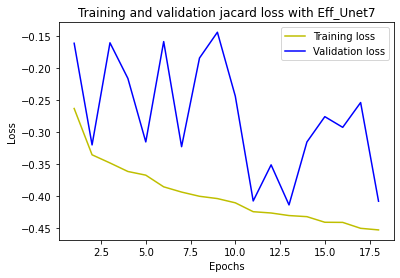

In [20]:
from matplotlib import pyplot as plt
loss = history_EFU77.history['loss']
val_loss = history_EFU77.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation jacard loss with Eff_Unet7')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

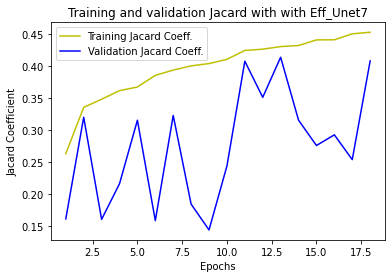

In [21]:
from matplotlib import pyplot as plt
jc = history_EFU77.history['jacard_coef']
#acc = history.history['accuracy']
val_jc = history_EFU77.history['val_jacard_coef']
#val_acc = history.history['val_accuracy']
#epochs = range(1, len(loss) + 1)

plt.plot(epochs, jc, 'y', label='Training Jacard Coeff.')
plt.plot(epochs, val_jc, 'b', label='Validation Jacard Coeff.')
plt.title('Training and validation Jacard with with Eff_Unet7')
plt.xlabel('Epochs')
plt.ylabel('Jacard Coefficient')
plt.legend()
plt.show()

##  make some mask prediction with Eff_Unet7

In [ ]:
#model.load_weights('model_0.h5')

batch_pred_masks = model_EFF_b7.predict(
    check_generator, 
    workers=1,
    verbose=1
)

In [ ]:
from matplotlib import pyplot as plt
for i in range(8):
    visualize(val_generator.getitem(i)[0][0,:,:,:],val_generator.getitem(i)[1][0,:,:,:],batch_pred_masks[i])